/var/folders/2q/t8yntc396z3d40tvc7nmptrm0000gn/T/ipykernel_25265/2602003420.py:47: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df, x="Tokens", y="Latency per Token (ms)", hue="Model", ci="sd")


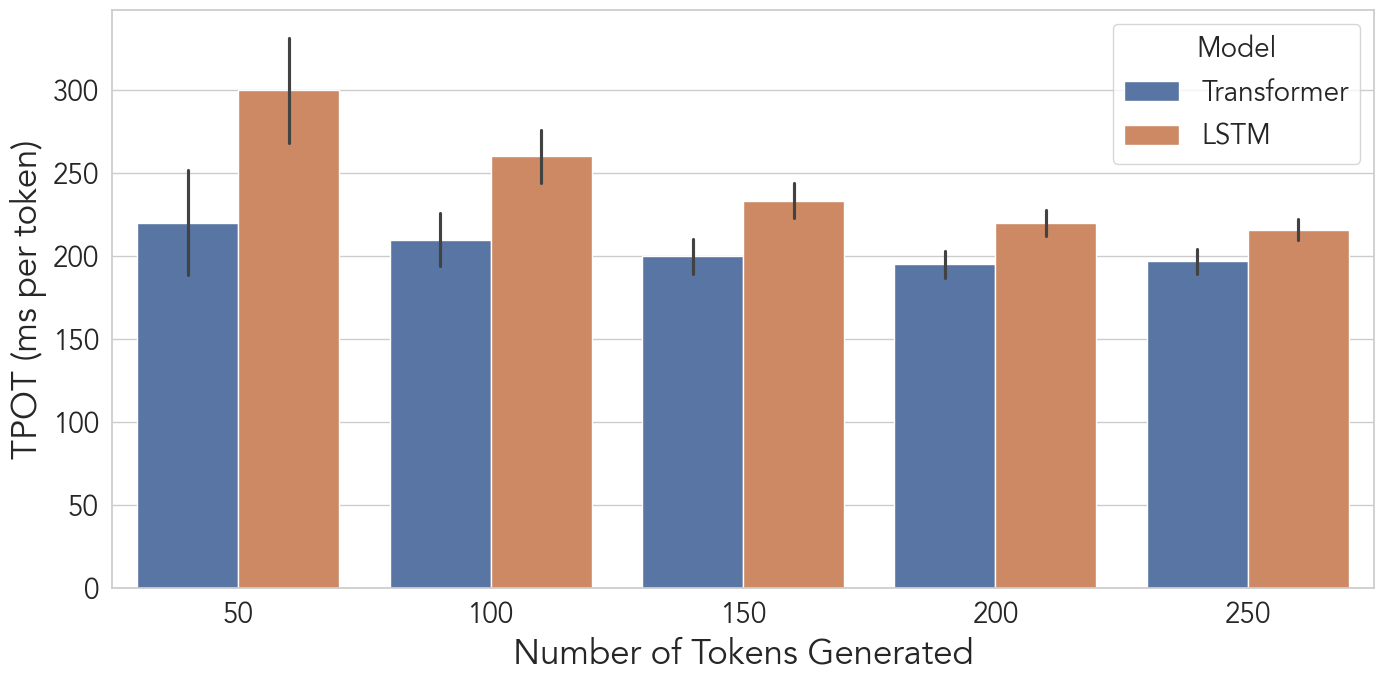

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Normalize latencies by number of tokens
normalized_transformer = {
    tokens: [lat / tokens for lat in latencies[tokens]] for tokens in latencies
}

normalized_lstm = {
    tokens: [lat / tokens for lat in lstm_latencies[tokens]] for tokens in lstm_latencies
}

# Prepare data for seaborn
plot_data = []
for tokens in normalized_transformer:
    for latency in normalized_transformer[tokens]:
        plot_data.append({"Tokens": tokens, "Latency per Token (ms)": latency * 1000, "Model": "Transformer"})
    for latency in normalized_lstm[tokens]:
        plot_data.append({"Tokens": tokens, "Latency per Token (ms)": latency * 1000, "Model": "LSTM"})

df = pd.DataFrame(plot_data)

# Set style and font
sns.set(style="whitegrid")
plt.rcParams.update({"font.family": "Avenir"})

# Create barplot
plt.figure(figsize=(14, 7))
sns.barplot(data=df, x="Tokens", y="Latency per Token (ms)", hue="Model", ci="sd")

# Adjust axis labels and font sizes
plt.xlabel("Number of Tokens Generated", fontsize=25)
plt.ylabel("TPOT (ms per token)", fontsize=25)

# Adjust tick label font size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Adjust legend
plt.legend(title="Model", title_fontsize=20, fontsize=20)

# Final layout adjustments
plt.tight_layout()

# Save and display the figure
plt.savefig('my_figure.svg', format='svg')
plt.show()

